# Imports

In [13]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [5]:
filename = 'data/diamonds.csv'

In [9]:
n = sum(1 for line in open(filename)) - 1
s = 2000
skip = sorted(random.sample(range(1, n+1), n-s))
df = pd.read_csv(filename, skiprows=skip)

In [10]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,28,0.30,Very Good,J,VS2,62.2,57.0,357,4.28,4.30,2.67
1,47,0.32,Very Good,H,SI2,61.8,55.0,403,4.35,4.42,2.71
2,111,0.80,Ideal,F,SI2,61.4,57.0,2761,5.96,6.00,3.67
3,166,0.73,Very Good,H,VVS1,60.4,59.0,2772,5.83,5.89,3.54
4,190,0.71,Good,F,VS2,63.8,58.0,2777,5.61,5.64,3.59


## Column Definitions

carat (num): weight in carats (1 carat = 200 mg) (0.2--5.01)

cut (cat): quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color (cat): diamond color (J (worst) -- D (best))

clarity (cat): how obvious inclusions are within the diamond (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

depth (num): height of diamond, measured from the culet (bottom tip) to the table (top), divided by its average girdle (widest dimension) diameter = z / mean(x, y) (43--79)

table (num): width of diamond's table (top) expressed as a percentage of its average diameter

price: price in US dollars (\$326--\$18,823)

x: length in mm (0--10.74)

y: width in mm (0--58.9)

z: depth in mm (0--31.8)

# Diamond Dimensions
<img src = 'data/diamondanatomyimproved.jpg'>

## EDA

### Data Distributions

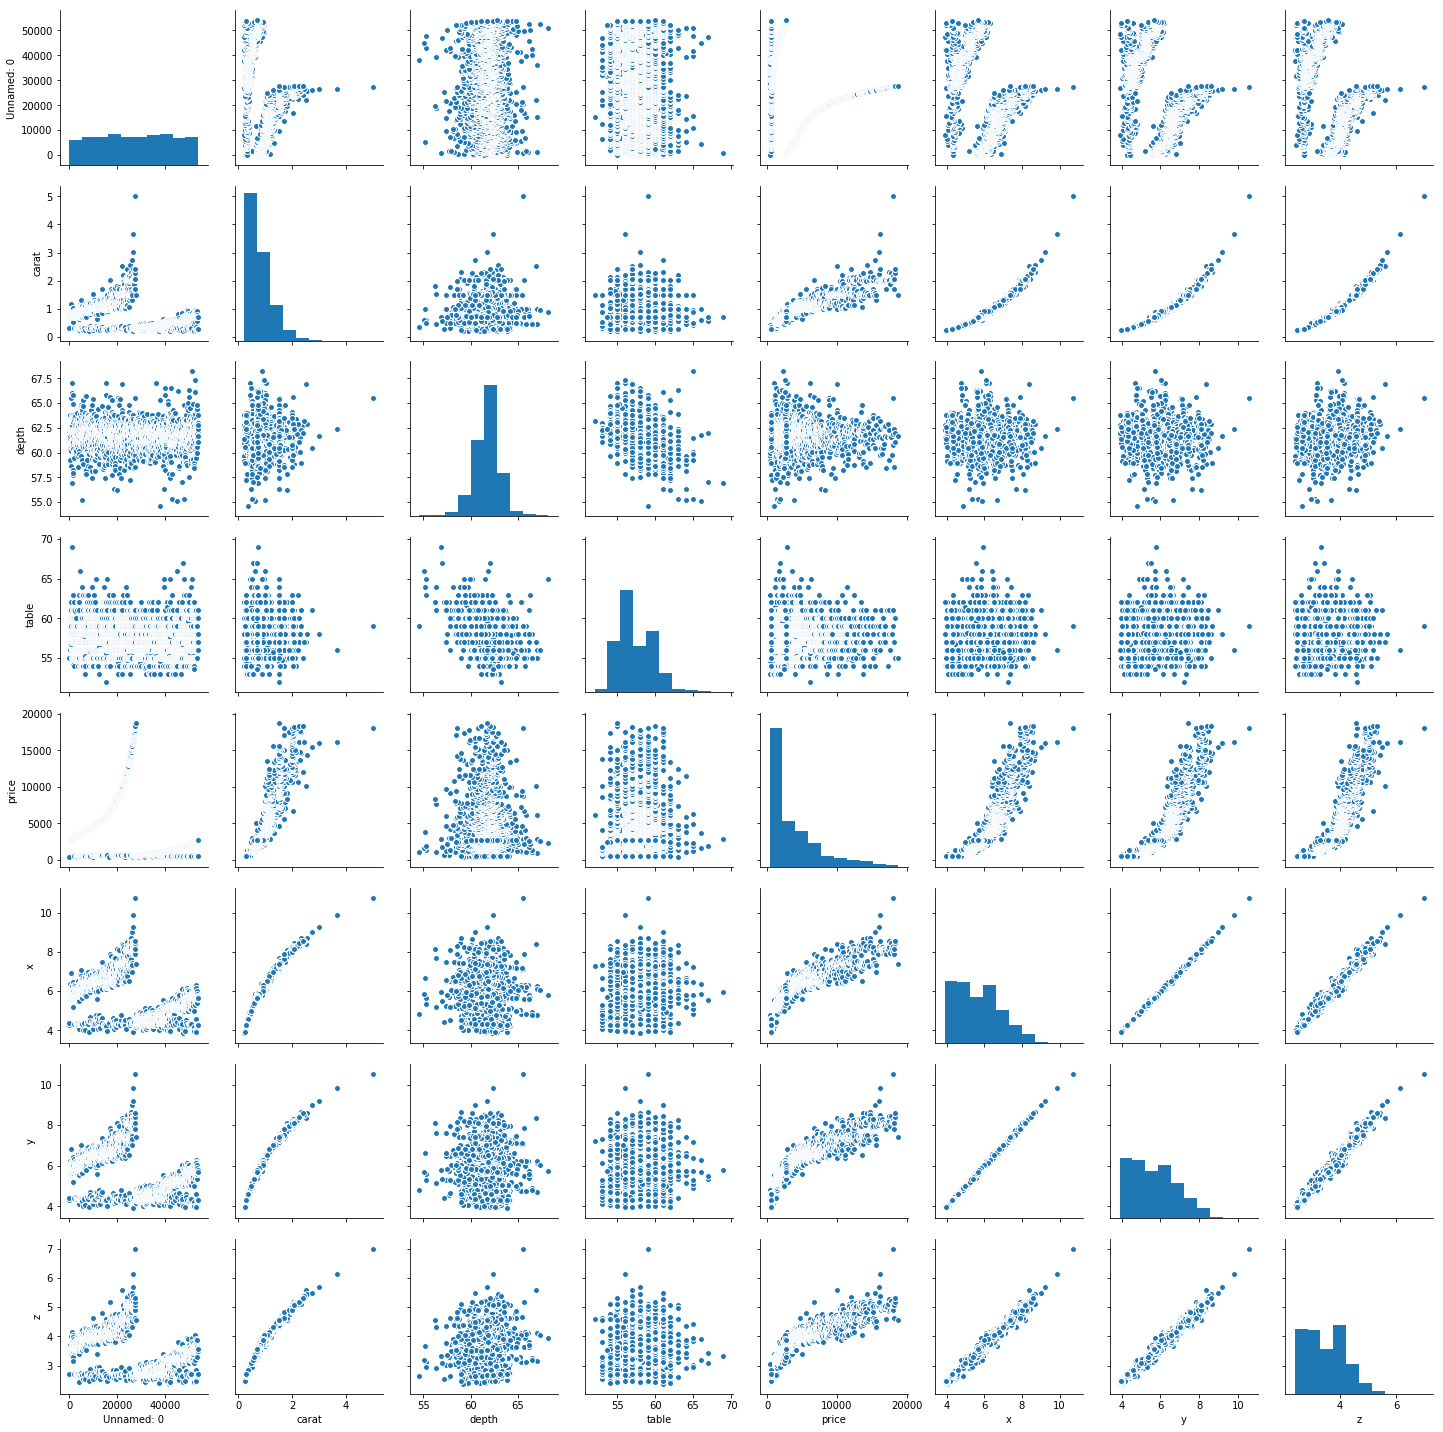

In [14]:
sns.pairplot(df);

Text(0,0.5,'Price ($)')

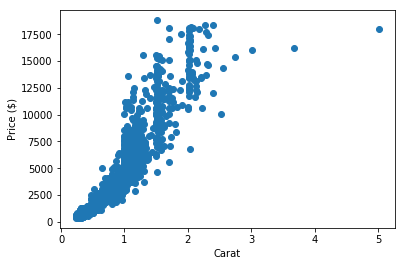

In [12]:
plt.scatter(df['carat'], df['price'])
plt.xlabel('Carat')
plt.ylabel('Price ($)')